### This notebook illustrates the content of the EXBA Light Curve Files released in Martinez-Palomera et al. 2021.


In [8]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib import colors

# Opening EXBA LCFs

First we'll explore the content of the multi-extension FITS file

In [9]:
# adjust the directory path as necessary 
lcf_name = '../data/export/5/27/lc_q5_ch27_Gaia_EDR3_2101136415390982528.fits.gz'
lcf = fits.open(lcf_name)

lcf.info()

Filename: ../data/export/5/27/lc_q5_ch27_Gaia_EDR3_2101136415390982528.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU     66   4492R x 20C   [D, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, J]   
  2  APERTURE_OPTIMAL    1 ImageHDU         8   (36, 60)   uint8   
  3  APERTURE1     1 ImageHDU         8   (36, 60)   uint8   
  4  APERTURE2     1 ImageHDU         8   (36, 60)   uint8   
  5  APERTURE3     1 ImageHDU         8   (36, 60)   uint8   
  6  APERTURE4     1 ImageHDU         8   (36, 60)   uint8   
  7  APERTURE5     1 ImageHDU         8   (36, 60)   uint8   
  8  APERTURE6     1 ImageHDU         8   (36, 60)   uint8   
  9  APERTURE7     1 ImageHDU         8   (36, 60)   uint8   


The FITS file has 10 HDU. 
* The PrimaryHDU has all the relevant metadata referring to the object, instrument, versions, etc. Important keywords are:
    * RA_OBJ and DEC_OBJ with the GAIA EDR# coordinates of the source
    * ROW and COLUMN which are the pixel coordinates of the object in the EXBA mask image
    * TPF_ORGN which is the TPF file where the source was detected
    * FLFRSAP# and CRWDSAP# that are the completeness and crowding metrics for every photometric aperture
* The BinTableHDU contains the light curve data for multiple photometric apertures sorted b columns. 
* The ImageHDUs have the aperture mask used for the photometry. The APERTURE_OPTIMAL refers to the optimized aperture that maximize the flux completeness and minize the contamination metrics. The rest of the APERTURE# are a sequence of increasing aperture sizes. Each aperture mask has shape 36 x 60 that matches the shape of the tiled EXBA aperture masks of the channel where the sources was detected.

In [10]:
# list of keywords in the Primary header
lcf[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'ApertureMACHINE'    / institution responsible for file               
DATE    = '2021-04-20'         / file creation date.                            
CREATOR = 'lightkurve.LightCurve.to_fits()' / pipeline job and program used t   
TELESCOP= 'Kepler  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
OBJECT  = 'Gaia EDR3 2101136

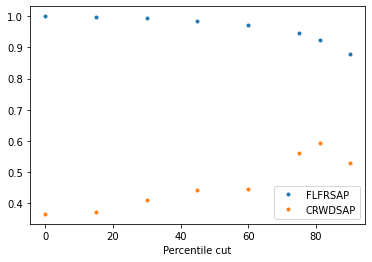

In [11]:
# example of flux metrics
percentile_cut = [lcf[0].header["PERCUTO"], 0 , 15, 30, 45, 60, 75, 90]

FLFRSAP = [lcf[0].header["FLFRSAPO"]] + [lcf[0].header["FLFRSAP%i" % i] for i in range(1,8)]
CRWDSAP = [lcf[0].header["CRWDSAPO"]] + [lcf[0].header["CRWDSAP%i" % i] for i in range(1,8)]

plt.plot(percentile_cut, FLFRSAP, ".", label="FLFRSAP")
plt.plot(percentile_cut, CRWDSAP, ".", label="CRWDSAP")
plt.legend(loc="best")
plt.xlabel("Percentile cut")
plt.show()

Wow! this source is very contaminated, lets see the aperture mask used. Later we'll inspect the full EXBA image to see the contaminants 

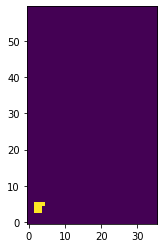

In [12]:
# plot of the mask used for the Optimazed aperture
plt.imshow(lcf[2].data, origin="lower")
plt.show()

To open the EXBA LCFs we can use the `lightkurve.KeplerLightCurve.read()` method. This will yield a LightCurve object that inherits all properties of the class such as plotting, corrector methods, periodograms, etc.

The different aperture flux are stored in different columns as follows:
* flux and flux_err are the measurements using the optimized aperture
* flux# and flux_err# with # from 1 to 7 are the measurements using the apertures in increasing size. The apertures are calculated as the isophote defined as the percentiles [0, 15, 30, 45, 60, 75, 90] values from the distribution of normalized flux value of the PRF evaluated source model.

The `quality` columns have the quality flags for every cadence as given by the original TPF files.

In [13]:
lc = lk.KeplerLightCurve.read(lcf_name)

In [14]:
lc

time,flux,flux_err,cadenceno,flux1,flux2,flux3,flux4,flux5,flux6,flux7,flux_err1,flux_err2,flux_err3,flux_err4,flux_err5,flux_err6,flux_err7,quality,sap_quality
,electron / s,electron / s,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,
object,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32
2455276.4901684504,1360.820556640625,3.0509719848632812,16373,6142.20263671875,6028.23681640625,5402.841796875,4043.93701171875,4035.2177734375,1413.3377685546875,1225.291259765625,6.812172889709473,6.249590873718262,5.704330921173096,5.052487850189209,4.420227527618408,3.4331986904144287,2.3652474880218506,16,0
2455276.5106028956,1320.2122802734375,3.0465593338012695,16374,6096.94580078125,5982.73095703125,5361.5986328125,4007.816162109375,3994.69921875,1373.8424072265625,1183.2530517578125,6.809321880340576,6.246406555175781,5.700949192047119,5.049250602722168,4.416576862335205,3.428972005844116,2.35988187789917,144,0
2455276.531037141,1340.2872314453125,3.048915147781372,16375,6140.755859375,6018.87255859375,5393.99951171875,4037.15625,4024.4169921875,1396.6258544921875,1205.8592529296875,6.811151504516602,6.248283386230469,5.702877044677734,5.051242351531982,4.41883659362793,3.431248188018799,2.362762928009033,144,0
2455276.5514714867,1372.1043701171875,3.051737070083618,16376,6169.66162109375,6049.65185546875,5425.17041015625,4076.195068359375,4059.13818359375,1433.574462890625,1229.2186279296875,6.812145709991455,6.249496936798096,5.70427131652832,5.053337574005127,4.420960426330566,3.4342260360717773,2.365906238555908,144,0
2455276.571905933,1368.5054931640625,3.0516393184661865,16377,6164.0615234375,6038.171875,5407.5625,4061.6796875,4049.627197265625,1426.3446044921875,1228.62353515625,6.812249660491943,6.249341011047363,5.703847885131836,5.0530476570129395,4.42097282409668,3.4338414669036865,2.3655221462249756,144,0
2455276.592340179,1365.7677001953125,3.0509235858917236,16378,6175.95703125,6046.9072265625,5417.34228515625,4066.29296875,4053.472412109375,1425.9278564453125,1227.5782470703125,6.811918258666992,6.248887538909912,5.703389644622803,5.05234432220459,4.420273780822754,3.4333512783050537,2.365572929382324,144,0
2455276.6127745253,1362.610107421875,3.0505218505859375,16379,6166.70166015625,6048.36181640625,5422.60791015625,4067.62841796875,4051.537841796875,1421.0804443359375,1224.9622802734375,6.8114423751831055,6.248924255371094,5.70370626449585,5.052435398101807,4.420114994049072,3.432852268218994,2.3651235103607178,144,0
2455276.6332089715,1369.1363525390625,3.051191568374634,16380,6175.66357421875,6051.87744140625,5426.1142578125,4070.6171875,4056.790771484375,1427.6341552734375,1227.9364013671875,6.8119683265686035,6.249185562133789,5.703850269317627,5.052585124969482,4.4204535484313965,3.4334378242492676,2.365527868270874,144,0


We can easily plot the light curves for all the apertures by iterating and passing the `column` keyword to the `.plot()` method  

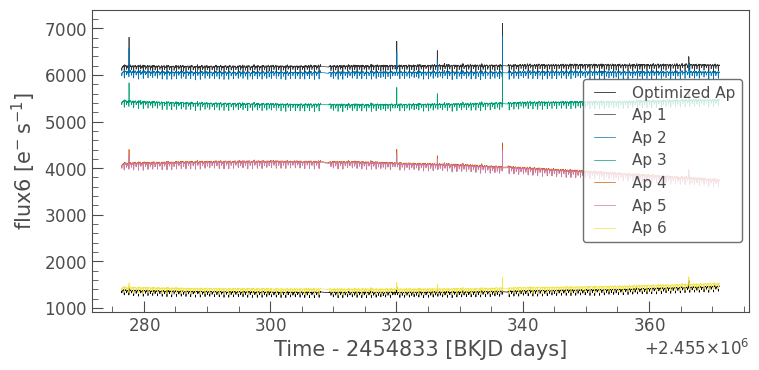

In [15]:
# light curve examples for different apertures
ax = lc.plot(c="k", label="Optimized Ap")
for i in range(1, 7):
    lc.plot(column="flux%i" % i, ax=ax, label="Ap %i" % i)

# Enhancing the plots with supporting files

Each quarter/channel package of LCFs are accompanied by a file containing an average image of the EXBA mask, as well as the catalog of Gaia EDR3 sources observed in the image.

Te purpose of these files is to enable an easy visualization of the EXBA stamp image, source catalog, and aperture mask, without downloading the full TPF that originate the LCF and re-quering Gaia. This is more relevant because the full EXBA masks (36 x 60 pixels) are made of 4 separated TPF (each of 9 x 60 pixels), and many sources are splitted in two TPFs.
This File can be open as follows:

In [16]:
# adjust the directory path as necessary 
img_hdu = fits.open("../data/export/5/27/image_q5_ch27_gaiadr3.fits.gz")
img_hdu.info()

Filename: ../data/export/5/27/image_q5_ch27_gaiadr3.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1                1 ImageHDU        13   (36, 60)   float32   
  2                1 BinTableHDU     59   106R x 24C   [29A, D, D, D, D, D, D, D, D, K, D, D, D, K, D, D, D, K, D, D, D, D, D, K]   


In [17]:
img_hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-18'         / file creation date.                            
CREATOR = '900750 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.23 r60353' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

Lets see the catalog of sources observed in this quarter and channel

In [18]:
catalog = Table(img_hdu[2].data)
catalog

designation,ra,ra_error,dec,dec_error,pmra,pmdec,parallax,parallax_error,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,col,row,clean_flag
str29,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
Gaia EDR3 2101136277956081920,290.6201536063706,0.14497891,40.38415711399749,0.14768293,-2.575328107678557,-6.211875505912358,-0.1120289592951337,0.16929312,371,440.369379428856,0.9216259,19.077824,41,181.717127171127,6.6518645,19.690052,35,350.21277468427536,7.651936,18.387066,583.7952583565412,559.024613479877,0
Gaia EDR3 2101136312312807168,290.6362176954422,0.02882482,40.394315698826354,0.029414615,-0.6976120640368831,-7.13988215135439,0.4147443162149016,0.033252854,425,6053.054863744351,2.4851496,16.23243,45,3248.0568758639683,9.005714,16.559483,45,3978.50864541686,8.599078,15.748594,569.504338672463,560.6923274693306,0
Gaia EDR3 2101136312312809344,290.63313603398666,0.1678147,40.397171783810336,0.16784446,-1.3678386513672804,-2.9146054749192,0.510188379324113,0.19481604,354,423.489951454248,0.9234685,19.120258,40,162.88802386351412,5.1636014,19.808819,38,353.29620808025413,8.120466,18.377548,569.8747440049856,564.016970671018,0
Gaia EDR3 2101136316610239744,290.62903587798525,0.14051795,40.38894706869735,0.13999997,-3.3211817808794737,-5.677095237922606,0.1086284869628778,0.16381815,371,462.9214620874585,0.9659988,19.023598,42,242.06066395138083,9.591331,19.37873,43,291.6234349527876,6.733478,18.58584,576.301324775419,559.3189804755488,0
Gaia EDR3 2101136316610248576,290.63327759315337,0.05913645,40.38812455391685,0.059908435,-5.653464919828343,-9.802797303228289,0.3251335424813027,0.06755282,401,1696.6122486544964,1.6659639,17.61341,46,927.7358513690768,11.44523,17.919981,43,1192.9223896467702,8.060807,17.056366,574.2573544368738,557.1007751350863,0
Gaia EDR3 2101136316610256256,290.63237248180843,0.08440905,40.39285470719847,0.08879771,-2.447996046506607,-3.3398330061495485,0.1078335583354794,0.09954214,411,885.4749398417529,1.1999466,18.319426,14,524.1997857137678,13.605625,18.5398,13,616.0940677345144,16.249514,17.773777,572.4459889459217,561.0291094373015,0
Gaia EDR3 2101136316614934400,290.6313559993018,0.018200785,40.38759138316465,0.0188485,-2.95791021994048,-10.262029241541946,1.1500956840335417,0.020823596,406,99031.96023480888,19.8318,13.197928,45,57330.12185048051,41.764664,13.442585,46,60121.77880556963,18.565763,12.800316,575.6303134809131,557.4185644657776,0
Gaia EDR3 2101136316614937856,290.63166387478225,0.037422292,40.39328529840057,0.03994293,-3.477910975321824,-4.464969831480856,0.258751106642309,0.044564933,424,3332.8957594471285,1.8023286,16.880312,44,1763.5734585045093,12.884796,17.222559,43,2294.4175625130133,12.846014,16.346214,572.642748715702,561.6220545695704,0
Gaia EDR3 2101136381032289024,290.6552920416306,0.21169843,40.40026191165925,0.20206106,-4.095754112244391,-7.298426845353592,0.1976333606633838,0.23526368,346,315.45778385854544,0.8529695,19.440014,37,145.47565502369454,6.8014846,19.931566,32,226.437639038264,8.477956,18.860523,555.5544353018608,558.0369216584585,0


Now we plot the EXBA stamp and the source catalog

In [19]:
# the time-average EXBA image
img = img_hdu[1].data

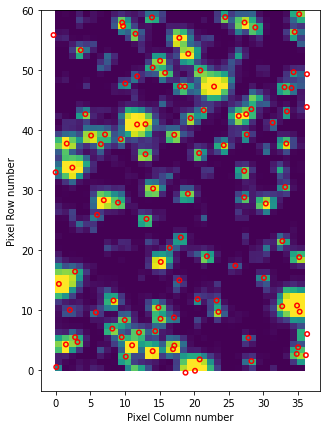

In [20]:
# example of how to plot the EXBA stamp and the source catalog
fig, ax = plt.subplots(1, figsize=(5, 7))
pc = ax.pcolormesh(
            img,
            shading="auto",
            cmap="viridis",
            norm=colors.SymLogNorm(linthresh=100, vmin=0, vmax=1000, base=10),
        )
ax.scatter(
        catalog["col"] - img_hdu[0].header["COL_0"] + 0.5,
        catalog["row"] - img_hdu[0].header["ROW_0"] + 0.5,
        s=20,
        facecolors="none",
        marker="o",
        edgecolors="r",
        linewidth=1.5,
        label="Gaia Sources",
)
ax.set_xlabel("Pixel Column number")
ax.set_ylabel("Pixel Row number")

plt.show()